# Stellar Modelling for TIC 350842552

## Setting up: Observed Inputs

In [1]:
# import os
# os.environ['OPENBLAS_NUM_THREADS'] = "1"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

In [2]:
# observed spectroscopic parameters
TARGETS = ['TIC 350842552']
props_obs = {
    TARGETS[0]: {
        'L': 174.6,
        'e_L': 10,
        'effective_T': 4318.047,
        'e_effective_T': 80,
        'FeH': -0.21,
        'e_FeH': 0.08,
        'Δν': 1.232,
        'e_Δν': 0.011,
        'nu_max': 7.5,
        'e_nu_max': 1,
    }
}

In [3]:
df = pd.read_csv("freqs.csv")

modes_obs = {
    TARGETS[0]: {_: df[_].values for _ in ['l', 'ν', 'e_ν', 'n']}
}

In [4]:
# plt.hist(prob.props['Δν'], bins=200, density=True)
# plt.axvline(props_obs[TARGETS[0]]['Δν'] - 1, c='red', ls='dashed')
# plt.axvline(props_obs[TARGETS[0]]['Δν'], c='red')
# plt.axvline(props_obs[TARGETS[0]]['Δν'] + 1, c='red', ls='dashed')
# plt.gca().set_xscale('log')

# plt.ylabel(r"Prior PDF")
# plt.xlabel(r"$\Delta\nu/\mu$Hz")
# plt.show()

## Setting up: Grid Search

In [5]:
import scipy.stats
from os import system

from grid_search.bootstrap import GridSearchProblem, observables

import scipy.stats

save_opts = dict(bbox_inches='tight', transparent=True)
def track_plot(model_name, TARGET, x='effective_T', y='nu_max', path="results"):
    track, profile = model_name.split('_')
    
    if 'profile' in prob.props.keys():
        if 'track' in prob.props.keys():
            df = prob.props[prob.props.track == track]
            r = df[df['profile'] == int(profile)]
        else:
            df = prob.props[[_.split('_')[0] == track for _ in prob.props.model_name.values]]
            r = df[df.model_name == f'{track}_{int(profile)}']
    else:
        df = prob.props[prob.props.track == int(track)]
        r = df[df['model_number'] == int(profile)]
        
    
    plt.plot(df[x], df[y])
    plt.errorbar(props_obs[TARGET][x], props_obs[TARGET][y],
                 xerr=props_obs[TARGET][f'e_{x}'], yerr=props_obs[TARGET][f'e_{y}'], fmt='.')
    
    plt.plot(r[x], r[y], marker='o', fillstyle='none')
    
    if x in ['effective_T']:
        plt.gca().invert_xaxis()
    if y in ['log_g', 'nu_max']:
        plt.gca().invert_yaxis()
        
    if y in ['L', 'nu_max']:
        plt.gca().set_yscale('log')
        
    plt.xlabel({'effective_T': r"$T_\mathrm{eff}/$K"}[x])
    plt.ylabel({
        'log_L': r"log $L/L_\odot$",
        'L': r"$L/L_\odot$",
        'log_g': r"$\log g$ [cgs]",
        'nu_max': r"$\nu_\mathrm{max}/\mu$Hz",
    }[y])
    plt.title(f"{model_name.replace('_', '-')}: $M = {float(r.star_mass):.3f}M_\\odot$")
#     plt.show()
    plt.gcf().set_size_inches(4,3)
    plt.savefig(f"{path}/{TARGET}.spec.pdf", **save_opts)
    plt.close('all')
    
def summarise(OUTNAME):
    samples = np.load(OUTNAME)
    quantiles = [[np.quantile(samples[:,i], scipy.stats.norm.cdf(cc)) for cc in [0, 1, -1]]
                     for i in range(prob.data.shape[1])]
    output = np.hstack([[q[0], (q[1]-q[0]), -(q[2]-q[0])]
                  for i, q in enumerate(quantiles)])
    np.savetxt(OUTNAME + '.dat', [output])

In [23]:
for grid in ['mass_loss']:
    prob = GridSearchProblem({}, [], PATH=f"grids/{grid}",
                             data=observables, tmpfs="/dev/shm/mass_loss")
    prob.props['L'] = np.power(10, prob.props.log_L)
    prob.props['nu_max'] = 3090 * prob.props['star_mass'] / np.power(10, prob.props['log_R'])**2 / np.sqrt(prob.props['effective_T']/5777)

    prob.props_obs = dict(**{_: dict(props_obs[_]) for _ in props_obs})
    
    for target in TARGETS:
        prob.props_obs[target]['Δν'] *= 1.0109 # surface term correction, Viani et al. 2018

    for lum in ['uselum']:

        outdir = f"Runs/{grid}"
        prob.outpath = outdir

        system(f"mkdir -p {outdir}")

        if 'use' in lum:
            prob.obs = ['L', 'FeH', 'effective_T']
        else:
            prob.obs = ['FeH', 'effective_T']

        for target in TARGETS:
            if np.isnan(props_obs[target]['Δν']) or np.isnan(props_obs[target]['nu_max']):
                print(f"No available seismology for {target}")
                continue
            try:
#                         prob.bootstrap(target, diagnostic_plots={'spec': track_plot},
#                                        overwrite=False, nthreads=16)
                χ2_bg, χ2_ε, χ2_low_n_1, χ2_low_n_2 = np.load(f"{outdir}/{target}.seis_costs.npy").T
                χ2_seis = χ2_bg #+ (χ2_low_n_1 + χ2_low_n_2)*.1
                norm = max(1, np.nanmin(χ2_seis))
                L_seis = np.exp(-χ2_seis/norm/2)
            except FileNotFoundError:
                L_seis = 1

            try:
                prob.bootstrap(target, diagnostic_plots={'spec': track_plot}, nthreads=16,
                               overwrite=False, L_seis=L_seis, std=False)
            except (ValueError, AssertionError) as e:
                tqdm.write(f"{e}")
                
            prob.gen_seis_mask(target, s_spec=slice(None, None))

/data/project1/joel/Modelling/zvrk/grid_search/bootstrap.py:150: RuntimeWarning: divide by zero encountered in log
  χ2 = np.sum(zm[:,s_grid]**2, axis=-1) - np.log(L_seis) * 2


[ 0.00874465  0.02306763 -0.1077491 ]
10c_661


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/joel/.local/lib/python3.10/site-packages/pandas-1.5.1-py3.10-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/1979 [00:00<?, ?it/s]

### Seismic Analysis with individual π-mode frequencies

In [21]:
from mesa_tricks.utils.selection import match_modes
from mesa_tricks.costs import low_n_cost, ε_cost, bgcost

from astropy import units as u
from os.path import isfile
from grid_search.seis import SeisIO, FAIL

N_LOW_MODES = 3
FAIL = [np.nan] * 4
def compute(Δν, info, modes_obs, model, p=True, trace=False,
            target=None, path="results"):
    
    # we only have p modes here
    matched = match_modes(modes_obs=modes_obs, modes_model=model, force_mod=False)

    χ2_bg, _ = bgcost(
        matched['ν_obs'], matched['e_obs'],
        matched['ν_model'], matched['E'],
        matched['ll'], l0_only=True
    )
    
    χ2_ε = ε_cost(matched['ν_obs'],  matched['e_obs'], matched['ν_obs'], matched['n_p'], matched['ll'], Δν, force_mod=False)
    if χ2_ε == 0:
        χ2_ε = np.inf

        
    if trace:
#         print(matched)
        for l in np.unique(matched['ll']):
            m = matched['ll'] == l
            plt.plot(matched['ν_obs'][m] % Δν, matched['ν_obs'][m], 'o', c=f"C{l}")
            plt.plot(matched['ν_model'][m] % Δν, matched['ν_model'][m], '.', c=f"C{l}")
        plt.show()
    
    χ2_low_n_1 = low_n_cost(matched['ν_obs'], matched['e_obs'], matched['ν_model'], n=N_LOW_MODES)
    χ2_low_n_2 = low_n_cost(-matched['ν_obs'], matched['e_obs'], -matched['ν_model'], n=N_LOW_MODES)
    return χ2_bg, χ2_ε, χ2_low_n_1, χ2_low_n_2
    

def model_seis_cost(Δν, modes_obs, model_name, params=None, trace=False, target=None, path='results'):
    try:
        model = seis_io.model_freqs(model_name)
    except (OSError, FileNotFoundError, EOFError):
        # OSError or EOFError: file is not a valid pickle
        return FAIL
    info = {}
    info['M'] = (params[int(model_name.replace('a', '').replace('b', '').replace('c', '').split('_')[0])][0] * u.M_sun).cgs.value
    info['target'] = target
    info['model_name'] = model_name
    try:
        return compute(Δν, info, modes_obs, model, trace=trace, target=target, path=path)
    except ValueError:
        return FAIL
    
def seis_cost(modes_obs, target, params):
    seis_mask = np.load(f"./Runs/{grid}/{target}.seis_mask.npy", allow_pickle=True)
    model_names = make_model_names(target)

    def job(model_name, *args, **kwargs):
        return model_seis_cost(props_obs[target]['Δν'], modes_obs[target], model_name,
        *args, **kwargs, target=target, params=params)
    seis_costs = np.array(tqdm_parallel_map(job, model_names, nthreads=16))
#     seis_costs = np.array(list(map(job, tqdm(prob.props['model_name'][seis_mask]))))
    out = np.ones((len(seis_mask), seis_costs.shape[-1])) * np.nan
    out[seis_mask] = seis_costs
    return out

def make_model_names(target):
    seis_names = np.load(f"./Runs/{grid}/{target}.seis_names.npy", allow_pickle=True)[()]
    keys = natsorted(seis_names.keys())
    names = [f"{t}_{i}" for t in keys for i in seis_names[t]]
    return names

In [19]:
from grid_search.seis import SeisIO
from natsort import natsorted
from mesa_tricks.utils import tqdm_parallel_map

for grid in ['mass_loss']:
    system(f"mkdir -p /dev/shm/{grid}")
    seis_io = SeisIO(f"./grids/{grid}/", f"/dev/shm/{grid}")
    params = np.load(f"grids/{grid}/params.npy", allow_pickle=True)[()]
    
    outdir = f"Runs/{grid}"

    for target in TARGETS:
        outname = f"{outdir}/{target}.seis_costs.npy"
        if not isfile(outname):
            np.save(outname, seis_cost(modes_obs, target, params))

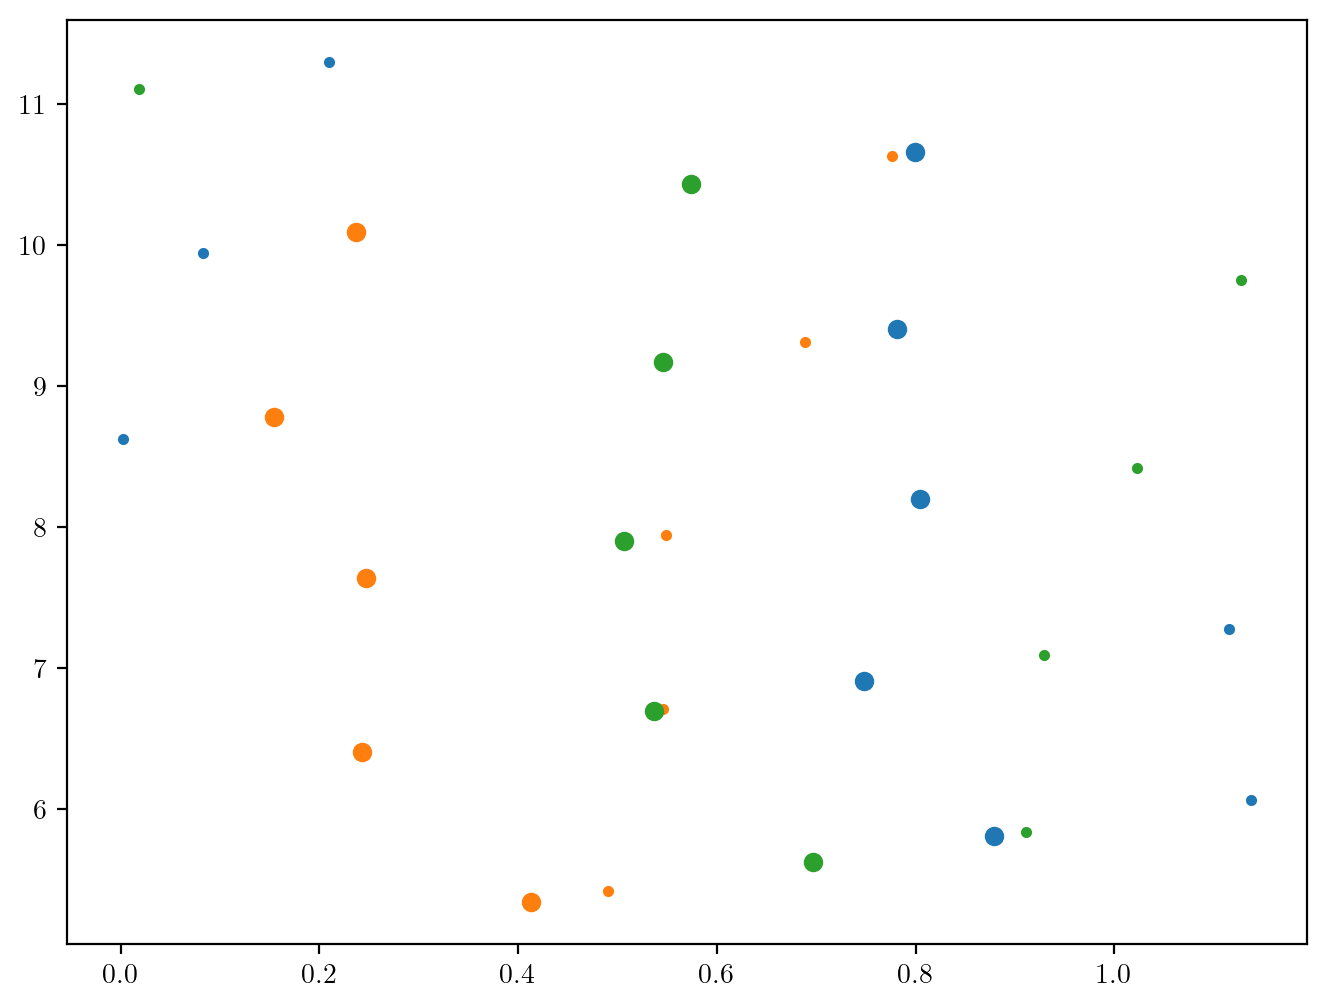

(9.55642550000256, 2.727381640207119e-29, 2.1778230342946236, 466.818434274811)

In [24]:
model_seis_cost(props_obs[TARGETS[0]]['Δν'],
                modes_obs[TARGETS[0]], '10c_661', trace=True,
               params=params)

### Corner Plots

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from grid_search.bootstrap import labels, observables
for grid in ['mass_loss']:
    samples = np.load(f"Runs/{grid}/TIC 350842552_seis_ONG.npy")
    corner(
        samples if len(samples.shape) == 2 else samples[:,0,:] + 0*np.random.normal(scale=np.nan_to_num(samples[:,1,:])), bins=30,
        labels=[labels[_] for _ in observables],
        truths=[props_obs[TARGETS[0]].get(_, None) for _ in observables]
    )
    plt.savefig(f"{grid}.png", bbox_inches='tight', transparent=True, dpi=150)
    plt.close('all')